In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

sns.set(style="whitegrid")

BASE_DIR = Path("..").resolve()
DATA_DIR = BASE_DIR / "data"
RESULTS_DIR = BASE_DIR / "results"
RESULTS_DIR.mkdir(exist_ok=True, parents=True)


In [2]:
df = pd.read_parquet(DATA_DIR / "scania_test_with_risk.parquet")

print(df.shape)
df.head()


(4710, 82)


,171_0,666_0,837_0,167_0,167_1,167_2,167_3,167_4,167_6,167_7,...,Spec_7_Cat4,Spec_7_Cat5,Spec_7_Cat6,Spec_7_Cat7,RUL,in_study_repair,vehicle_id,surv_prob_at_T,t_horizon,risk_group
0,3267180.0,80774.0,6692.0,14121.0,14611533.0,38731894.0,13485650.0,30548482.0,11480012.0,268128.0,...,False,False,False,False,5.0,0,18521,0.840370,50.0,low
1,8399850.0,349538.0,116164.0,22281.0,12885921.0,23534515.0,16716669.0,58702569.0,14333888.0,672613.0,...,False,False,False,False,3.2,1,336,0.657211,50.0,medium
2,3955200.0,131341.0,20981.0,3123.0,4280735.0,18775382.0,19149289.0,40064733.0,28733180.0,1371425.0,...,False,False,False,False,1.8,0,14425,0.721114,50.0,medium
3,3583080.0,88699.0,29250.0,4070.0,5320727.0,11424708.0,10498830.0,24649757.0,16478777.0,475580.0,...,False,False,False,False,11.8,0,19409,0.804316,50.0,low
4,6723180.0,45627.0,156.0,52521.0,9708537.0,53520074.0,54025183.0,122050774.0,1216133.0,0.0,...,False,False,False,False,1.0,0,1924,0.891631,50.0,low


In [3]:
COST_FAILURE = 100_000        # unexpected breakdown
COST_PREVENTIVE = 20_000      # planned maintenance
COST_INSPECTION = 2_000       # inspection cost


In [4]:
def maintenance_cost(row):
    """
    Decide cost based on predicted risk and actual outcome.
    """
    if row["risk_group"] == "high":
        # We act early
        return COST_PREVENTIVE + COST_INSPECTION
    else:
        # No action taken
        if row["in_study_repair"] == 1:
            return COST_FAILURE
        else:
            return 0


In [5]:
df["cost_with_model"] = df.apply(maintenance_cost, axis=1)


In [6]:
df["cost_without_model"] = df["in_study_repair"].apply(
    lambda x: COST_FAILURE if x == 1 else 0
)


In [7]:
total_cost_with_model = df["cost_with_model"].sum()
total_cost_without_model = df["cost_without_model"].sum()

savings = total_cost_without_model - total_cost_with_model

print("Total cost WITHOUT model : ₹", total_cost_without_model)
print("Total cost WITH model    : ₹", total_cost_with_model)
print("Estimated savings        : ₹", savings)


Total cost WITHOUT model : ₹ 45400000
Total cost WITH model    : ₹ 42788000
Estimated savings        : ₹ 2612000


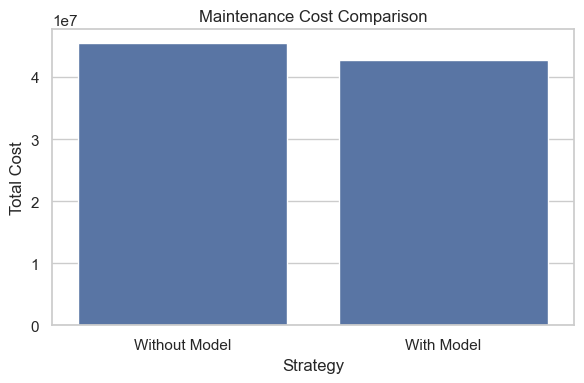

In [8]:
cost_df = pd.DataFrame({
    "Strategy": ["Without Model", "With Model"],
    "Total Cost": [total_cost_without_model, total_cost_with_model]
})

plt.figure(figsize=(6, 4))
sns.barplot(data=cost_df, x="Strategy", y="Total Cost")
plt.title("Maintenance Cost Comparison")
plt.ylabel("Total Cost")
plt.tight_layout()
plt.show()


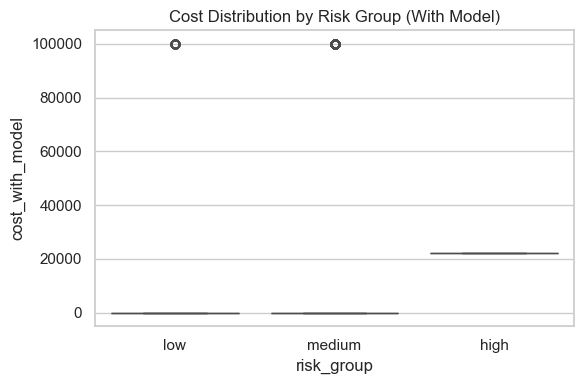

In [9]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df,
    x="risk_group",
    y="cost_with_model",
    order=["low", "medium", "high"]
)
plt.title("Cost Distribution by Risk Group (With Model)")
plt.tight_layout()
plt.show()
